# Exploratory analysis and merge of 2 different datasets and making one dataset from it

## Installing and setting up Colab

In [1]:
# Imports

import os
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Using SciencePlots
! pip install SciencePlots
! pip install matplotlib==3.5.1

import matplotlib.pyplot as plt

plt.style.use(['science', 'notebook', 'grid'])
SEED = 2908

In [3]:
# Adding kaggle lib to download datasets

! pip install kaggle
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/FER_project/kaggle.json ~/.kaggle/kaggle.json

In [5]:
# Download datasets
! kaggle datasets download -d 'msambare/fer2013'
! kaggle datasets download -d 'shawon10/ckplus'

# Unzip
! unzip -q fer2013.zip -d fer_ds
! unzip -q ckplus.zip -d ckplus_ds

! rm -rf fer2013.zip ckplus.zip ckplus_ds/ck
! mv ckplus_ds/CK+48/* ckplus_ds/.
! rm -rf ckplus_ds/CK+48

 68% 41.0M/60.3M [00:02<00:00, 21.4MB/s]
100% 60.3M/60.3M [00:02<00:00, 26.2MB/s]
  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 125MB/s]


## Analyze FER2013 Dataset

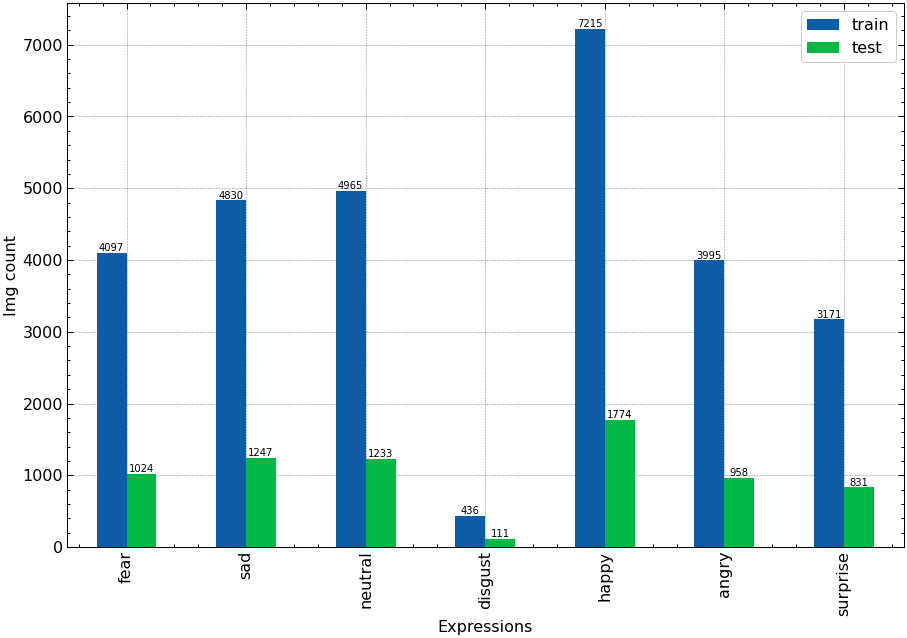

In [6]:
train_dir = 'fer_ds/train/'
test_dir = 'fer_ds/test/'

def count_exp(path, set_):
  '''Creates dataframe for images count per expression'''
  dict_ = {}
  for expression in os.listdir(path):
      dir_ = path + expression
      dict_[expression] = len(os.listdir(dir_))
  df = pd.DataFrame(dict_, index=[set_])
  return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
fer_ds_count = pd.concat([train_count, test_count])
ax = fer_ds_count.transpose().plot(kind='bar', xlabel='Expressions', ylabel='Img count', figsize=(15, 10));

for container in ax.containers:
  ax.bar_label(container)

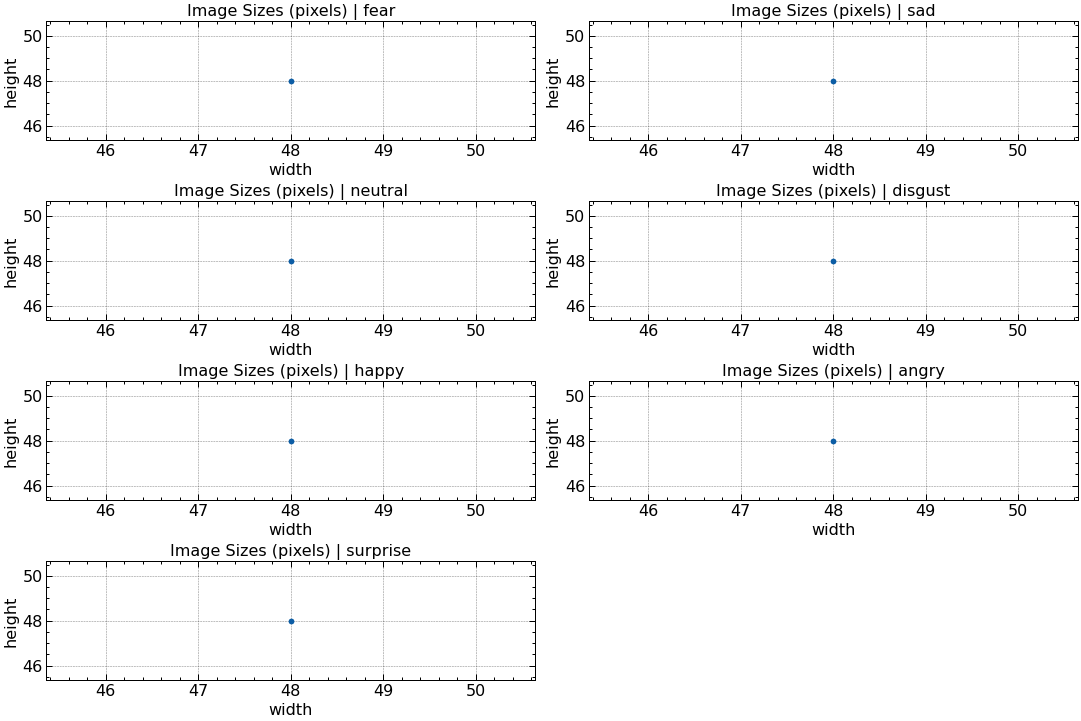

In [7]:
def img_dims(dir):
  '''Return dataframe for images dimensions per expression'''
  
  def _get_dims(file):
    '''Returns dimenstions for an image'''
    im = plt.imread(file)
    arr = np.array(im)
    h, w = arr.shape
    return h, w
      
  dims = [_get_dims(os.path.join(dir, filename)) for filename in os.listdir(dir)]
  dim_df = pd.DataFrame(dims, columns=['height', 'width'])
  sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
  return sizes
  
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(15, 10));
for i, expression in enumerate(os.listdir(train_dir)):
  train_df = img_dims(os.path.join(train_dir, expression))
  test_df = img_dims(os.path.join(test_dir, expression))
  df = pd.concat([train_df, test_df])
  df.plot.scatter(x='width', y='height', ax=axes[i//2, i%2]);
  axes[i//2, i%2].title.set_text('Image Sizes (pixels) | {}'.format(expression));
fig.delaxes(axes[3, 1])

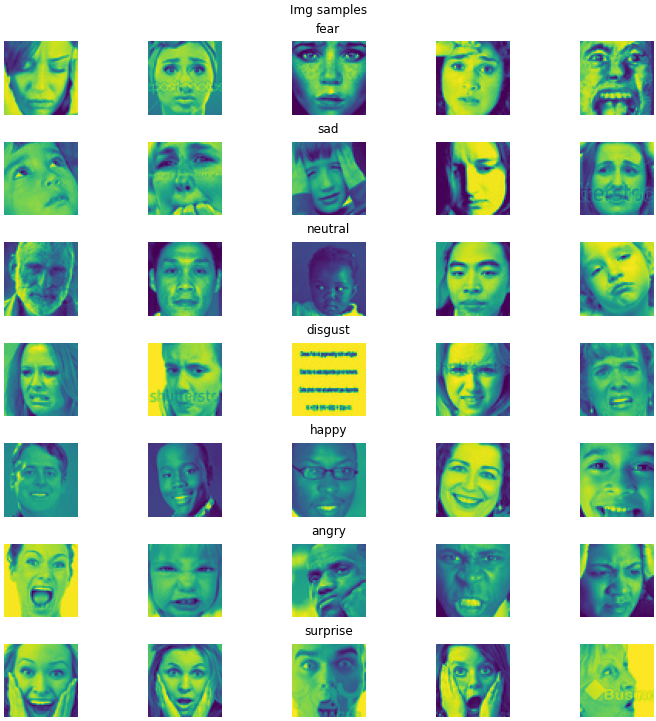

In [8]:
def show_img_samples(img_samples):
  expressions = list(img_samples.keys())
  num_expressions = len(expressions)

  fig = plt.figure(constrained_layout=True, figsize=(10, 10));
  fig.suptitle('Img samples')

  # create num_expressions x 1 subfigs
  subfigs = fig.subfigures(nrows=num_expressions, ncols=1);
  for row, subfig in enumerate(subfigs):
    expression = expressions[row]
    subfig.suptitle(f'{expression}')

    # create 1 x NUM_IMGS subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=NUM_IMGS)
    for col, ax in enumerate(axs):
      img = plt.imread(img_samples[expression][col])
      ax.axis('off')
      ax.imshow(img);

NUM_IMGS = 5
img_samples = {}
for expression in os.listdir(train_dir):
  dir_ = os.path.join(train_dir, expression)
  img_samples[expression] = random.sample([os.path.join(dir_, filename) for filename in os.listdir(dir_)], NUM_IMGS)

show_img_samples(img_samples)

## Analyze CK+ Dataset

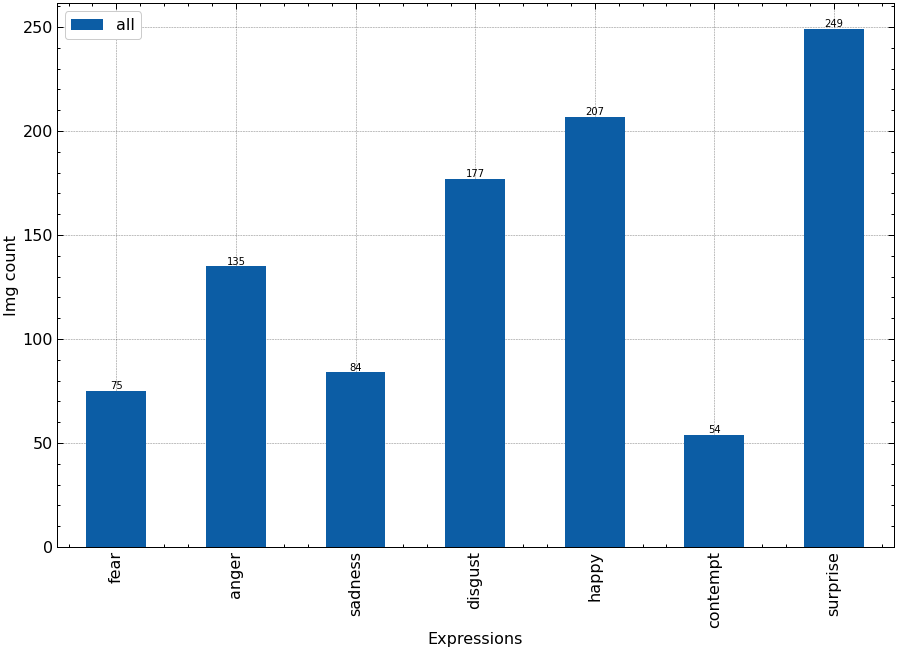

In [9]:
ckplus_dir = 'ckplus_ds/'

ckplus_count = count_exp(ckplus_dir, 'all')
ax = ckplus_count.transpose().plot(kind='bar', xlabel='Expressions', ylabel='Img count', figsize=(15, 10));

for container in ax.containers:
  ax.bar_label(container)

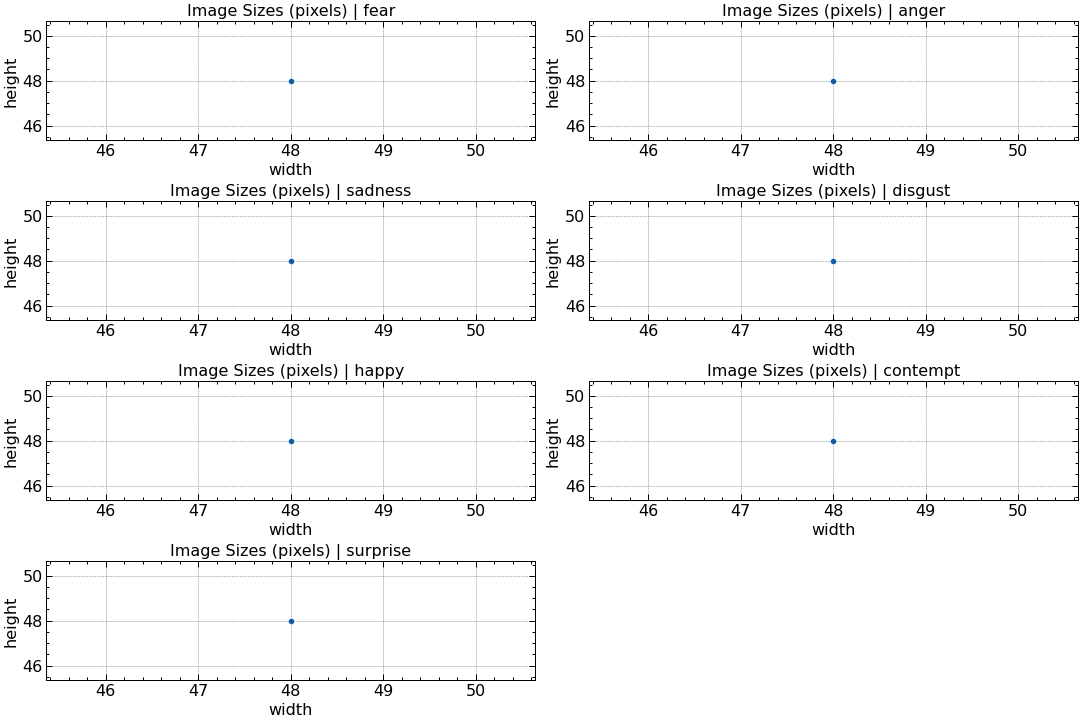

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(15, 10));
for i, expression in enumerate(os.listdir(ckplus_dir)):
  df = img_dims(os.path.join(ckplus_dir, expression))
  df.plot.scatter(x='width', y='height', ax=axes[i//2, i%2]);
  axes[i//2, i%2].title.set_text('Image Sizes (pixels) | {}'.format(expression));
fig.delaxes(axes[3, 1])

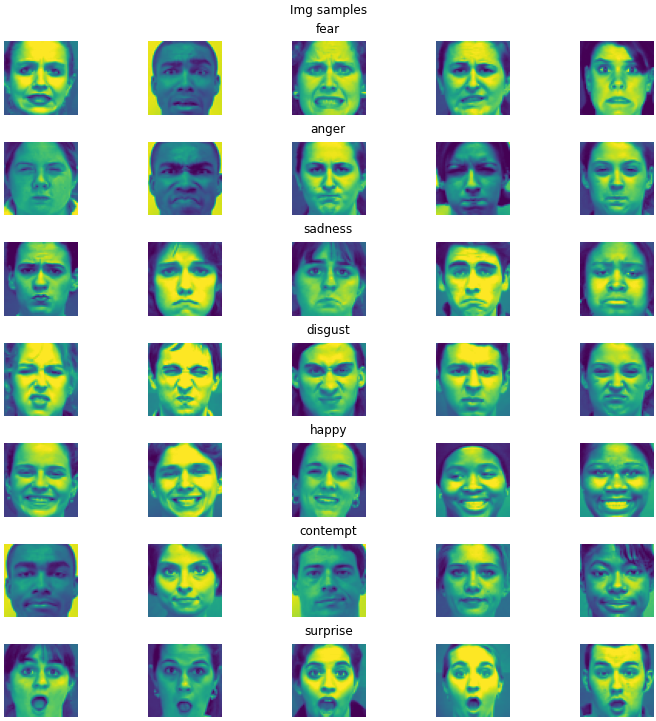

In [11]:
img_samples = {}
for expression in os.listdir(ckplus_dir):
  dir_ = os.path.join(ckplus_dir, expression)
  img_samples[expression] = random.sample([os.path.join(dir_, filename) for filename in os.listdir(dir_)], NUM_IMGS)

show_img_samples(img_samples)

## Merge into new DFERP_DS

From above analysis of the datasets give us the next conclusions:
- Both have same image dimensions (48, 48, 1)
- Both have centered face image
- FER-2013 is much bigger dataset then ckplus
- CKPLUS doesn't come in presplitted trian/test set
- FER-2013 have some side face variations
- We see that both of them might contain some labeling errors (This is high level fruit, so we leave this as a final resort in case our model is having degrading result)

So next steps are:
- Merge disgust and contempt into disgust label (both emotions are negative emotions, usually to someone or something, so we merge them)
- Rename expressions of CKPLUS to match the ones in FER-2013
- Split CKPLUS on train/test set
- Merge CKPLUS with FER-2013
- Add data agumentation (later step in case that our model is having degrading results)


In [12]:
! mkdir dferp_ds
! cp -R fer_ds/* dferp_ds/.

In [13]:
# Split CKPLUS and merge with FER-2013
expression_remap = {
    'anger': 'angry',
    'contempt': 'disgust',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'sadness': 'sad',
    'surprise': 'surprise'
}  

# Create dict with remaped expressions and train/test split
train_ds = {}
test_ds = {}
for expression in os.listdir(ckplus_dir):
  dir_ = os.path.join(ckplus_dir, expression)
  imgs = [os.path.join(dir_, img) for img in os.listdir(dir_)]
  train_imgs, test_imgs = train_test_split(imgs, test_size=0.3, random_state=SEED)
  
  expression = expression_remap[expression]
  existing_train_imgs = train_ds.get(expression, [])
  existing_train_imgs.extend(train_imgs)
  train_ds[expression] = existing_train_imgs
  
  existing_test_imgs = test_ds.get(expression, [])
  existing_test_imgs.extend(test_imgs)
  train_ds[expression] = existing_test_imgs

def write_to(dict_, target_dir):
  '''Write dict into new target dir'''
  for expression, imgs in dict_.items():
    dest = os.path.join(target_dir, expression)
    
    if not os.path.exists(dest):
      os.mkdir(dest)
    
    for img in imgs:
      shutil.copy(img, dest)

write_to(train_ds, 'dferp_ds/train/')
write_to(test_ds, 'dferp_ds/test/')

## Analyize DFERP

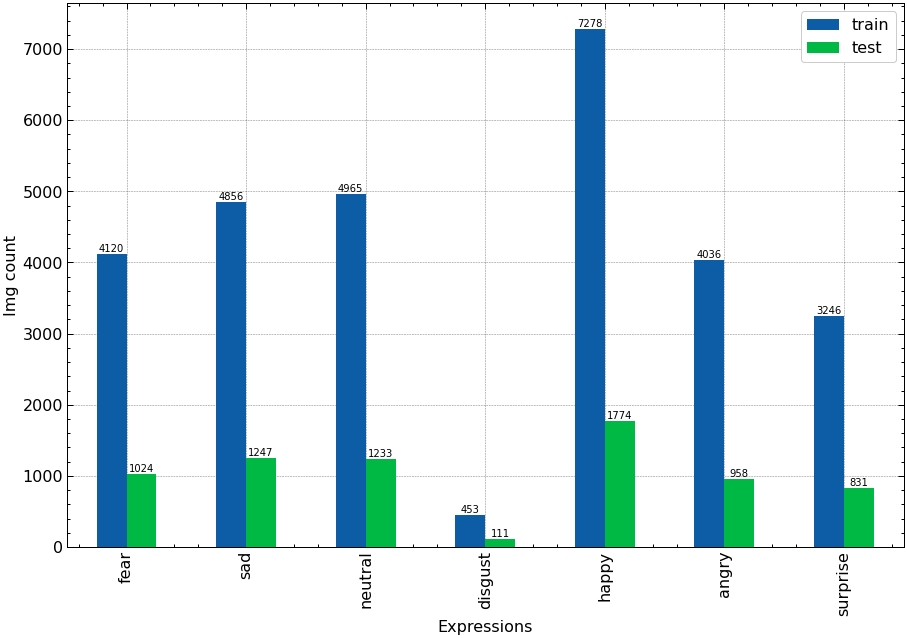

In [15]:
train_dir = 'dferp_ds/train/'
test_dir = 'dferp_ds/test/'

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
fer_ds_count = pd.concat([train_count, test_count])
ax = fer_ds_count.transpose().plot(kind='bar', xlabel='Expressions', ylabel='Img count', figsize=(15, 10));

for container in ax.containers:
  ax.bar_label(container)

In [16]:
! zip -r dferp_ds.zip dferp_ds/
! mv dferp_ds.zip drive/MyDrive/FER_project/ProcessedData/

Streaming output truncated to the last 5000 lines.
  adding: dferp_ds/train/angry/Training_20531010.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_23625584.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_38557671.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_52504873.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_66097651.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_68189647.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_70451794.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_76507946.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_96129692.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_96761334.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_60936737.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_49098272.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_56915487.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training_88051794.jpg (stored 0%)
  adding: dferp_ds/train/angry/Training